# Crosswalk

In this notebook we demonstrate how to define a crosswalk with pedestrians using AutomotiveDrivingModels. The last part also hows how to save a video from a simulation.

In [1]:
using AutomotiveDrivingModels

# All the functions related to visualization
using AutoViz
AutoViz.colortheme["background"] = colorant"white"; # set the background color to white
using Random

┌ Info: Precompiling AutoViz [82aa6e0c-a491-5edf-8d4b-c16b98e4ea17]
└ @ Base loading.jl:1273


## Generate a crosswalk environment

In this second example we demonstrate how to define a crosswalk area as well as a pedestrian agent type.

We define a new concrete type that will contain the roadway (where cars drive) and the crosswalk definition which is just a regular lane.

In [2]:
struct CrosswalkEnv
    roadway::Roadway{Float64}
    crosswalk::Lane{Float64}
end

The crosswalk lane consists of a straight road segment perpendicular to the road. We will define the roadway just as a straight road.

In [3]:
# geometry parameters
roadway_length = 50.
crosswalk_length = 20.
crosswalk_width = 6.0
crosswalk_pos = roadway_length/2

# Generate straight roadway of length roadway_length with 2 lanes
roadway = gen_straight_roadway(2, roadway_length) 

# generate the crosswalk
n_samples = 2 # for curve generation
crosswalk = Lane(LaneTag(2,1), gen_straight_curve(VecE2(crosswalk_pos, -crosswalk_length/2),
                                                  VecE2(crosswalk_pos, crosswalk_length/2),
                                                   n_samples), width = crosswalk_width)
cw_segment = RoadSegment(2, [crosswalk])
push!(roadway.segments, cw_segment) # append it to the roadway


# initialize crosswalk environment
env = CrosswalkEnv(roadway, crosswalk);

**Render the crosswalk**

We will define a new method to render this new environment. The roadway part is just rendered regularly, we add specific instuction for the crossswalk part that will display the white stripes.

In [4]:
function AutoViz.add_renderable!(rendermodel::RenderModel, env::CrosswalkEnv)
    roadway = gen_straight_roadway(2, roadway_length) # only render the road and not the crosswalk
    add_renderable!(rendermodel, roadway)
    
    # render crosswalk
    curve = env.crosswalk.curve
    n = length(curve)
    pts = Array{Float64}(undef, 2, n)
    for (i,pt) in enumerate(curve)
        pts[1,i] = pt.pos.x
        pts[2,i] = pt.pos.y
    end

    add_instruction!(rendermodel, render_dashed_line, (pts, colorant"white", env.crosswalk.width, 1.0, 1.0, 0.0, AutoViz.Cairo.CAIRO_LINE_CAP_BUTT))
    return rendermodel
end

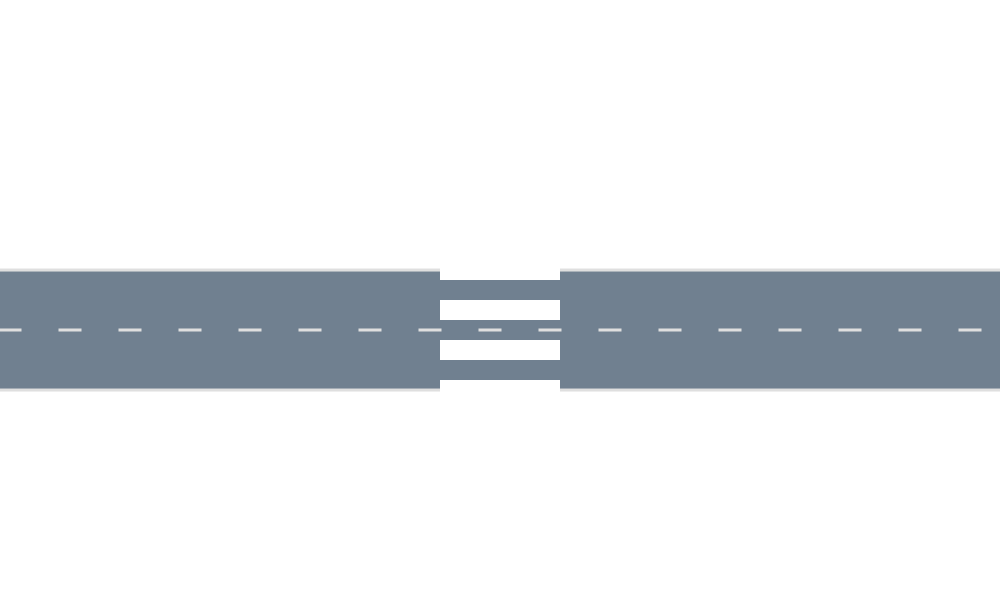

In [5]:
cam = StaticCamera(position=VecE2(roadway_length/2, 3.), zoom=20.0)
render([env], camera = cam)

### Navigate the crosswalk example

Cars will be navigating in the roadway just as before. For the pedestrian we can define a new vehicle definition where we specify the size of the bounding box represented by the pedestrian.

In [6]:
# field of the VehicleDef type
fieldnames(VehicleDef)

(:class, :length, :width)

In [7]:
# Agent.Class is from AutomotiveDrivingModels
const PEDESTRIAN_DEF = VehicleDef(AgentClass.PEDESTRIAN, 1.0, 1.0)

VehicleDef(PEDESTRIAN, 1.000, 1.000)

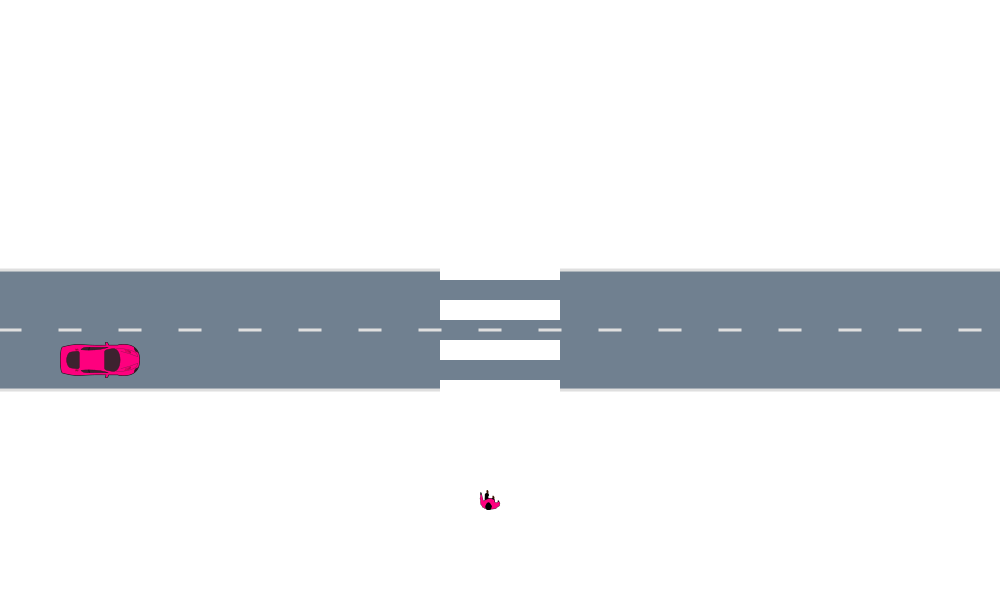

In [8]:
# Car definition
car_initial_state = VehicleState(VecSE2(5.0, 0., 0.), roadway.segments[1].lanes[1],roadway, 8.0)
car = Vehicle(car_initial_state, VehicleDef(), 1)

# Pedestrian definition using our new Vehicle definition
ped_initial_state = VehicleState(VecSE2(+24.5,-7.0,π/2), env.crosswalk, roadway, 0.5)
ped = Vehicle(ped_initial_state, PEDESTRIAN_DEF, 2)

scene = Scene([car, ped])

# visualize the initial state
render([env, scene], camera=cam)

### Simulate!

As before, associate a driver model to each vehicle in the scene. We will use the model defined in the intersection example for both agents.

In [9]:
mutable struct LinearDriver <: DriverModel{LaneFollowingAccel}
    a::LaneFollowingAccel

    p::Float64 # confidence on the pedestrian intention
    k::Float64 # gain
end

In [10]:
function AutomotiveDrivingModels.get_name(model::LinearDriver) 
    return "linear driver"
end

Base.rand(rng::AbstractRNG, model::LinearDriver) = model.a


function AutomotiveDrivingModels.observe!(model::LinearDriver, scene::EntityFrame{VehicleState, VehicleDef, Int64}, roadway::Roadway, egoid::Int) 
    model.a = LaneFollowingAccel(model.k*model.p)
    
    # change the confidence based on some policy
    # you can get the position of the pedestrian from the scene
    model.p = 100.0
end

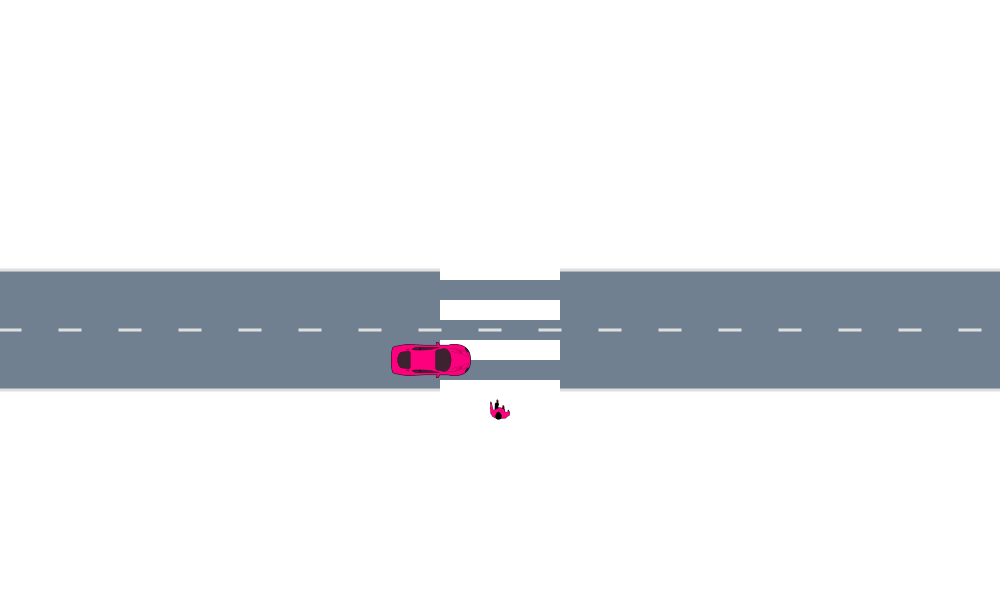

In [11]:
timestep = 0.1


# reset the initial scene
# Car definition
car_initial_state = VehicleState(VecSE2(5.0, 0., 0.), roadway.segments[1].lanes[1],roadway, 8.0)
car = Vehicle(car_initial_state, VehicleDef(), 1)

# Pedestrian definition using our new Vehicle definition
ped_initial_state = VehicleState(VecSE2(+24.5,-7.0,π/2), env.crosswalk, roadway, 0.5)
ped = Vehicle(ped_initial_state, PEDESTRIAN_DEF, 2)

scene = Scene()
push!(scene, car)
push!(scene, ped)

# define a model for each entities present in the scene
models = Dict{Int, DriverModel}()

ego_id = 1
ped_id = 2
# Constant speed model
models[ego_id] = LinearDriver(LaneFollowingAccel(0.0), 20.0, -0.02)
models[ped_id] = IntelligentDriverModel(v_des=1.0) # dumb model

nticks = 50

# execute the simulation
scenes = simulate(scene, roadway, models, nticks, timestep)

render([env, last(scenes)], camera=cam)

## Generate a video with Reel.jl

In [12]:
using Reel
Reel.set_output_type("mp4")

"mp4"

In [13]:
frames = Frames(MIME("image/png"), fps=Int(1/timestep))
for s in scenes 
    push!(frames, render([env, s], camera=cam))
end
frames

Frames{MIME{Symbol("image/png")}}("C:\\Users\\Maxime\\AppData\\Local\\Temp\\jl_Ne4OQo", 0x0000000000000033, 10.0, nothing)